# <font color = 'orange'> Build Features

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2

---

### Load Data

In [3]:
df = pd.read_pickle('../../data/interim/02_outlier_removed_chauvenet.pkl')

predictor_columns = df.columns[:6]

In [4]:
predictor_columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z'], dtype='object')

---

###  Dealing with missing values (imputation)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [6]:
for col in predictor_columns:
    df[col] = df[col].interpolate()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


---

###  Calculating set duration

<AxesSubplot: xlabel='epoch (ms)'>

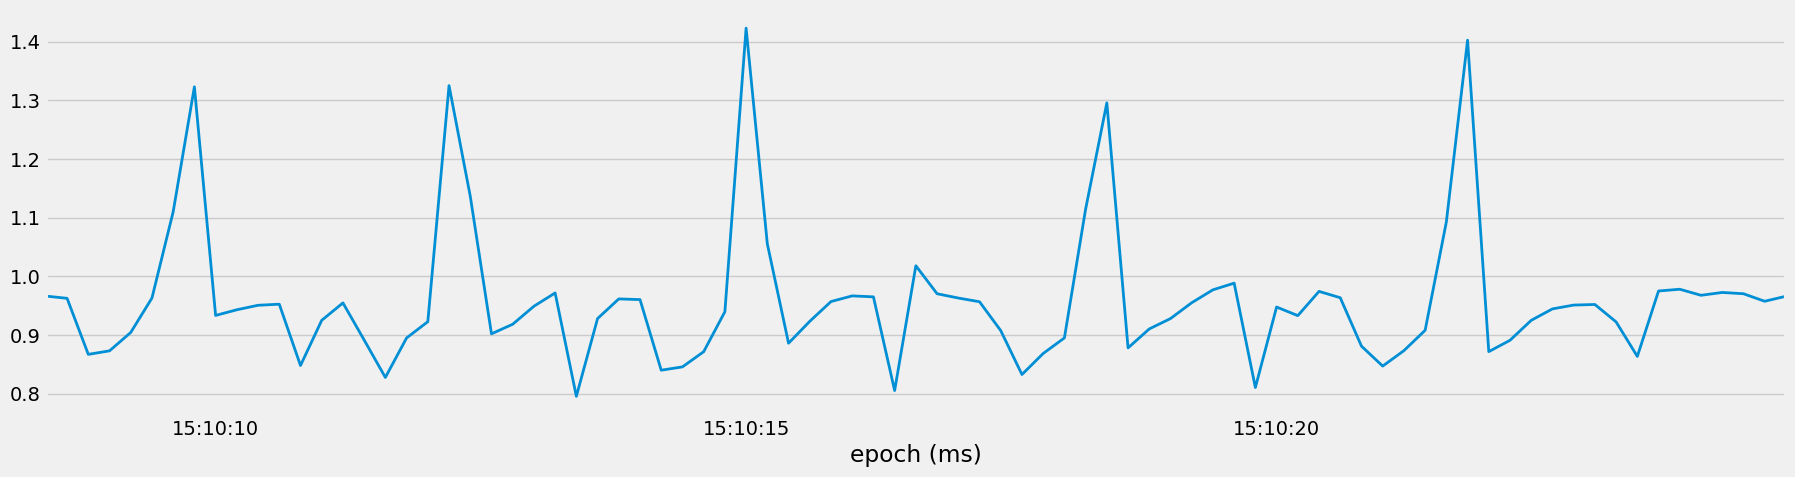

In [8]:
df[df['set'] == 1]['acc_y'].plot()
# observation: we can see some pattern in the plot so we can smoothen the curve to get the pattern

In [9]:
for s in df['set'].unique():
    start = df[df['set'] == s].index[0]
    stop = df[df['set'] == s].index[-1]
    
    duration = stop - start
    df.loc[df['set'] == s, 'duration'] = duration.seconds

In [10]:
duration_df = df.groupby(['category'])['duration'].mean()

duration_df

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [11]:
print(duration_df.iloc[0] / 5)
print(duration_df.iloc[1] / 10)

2.9487001733102254
2.4942528735632186


---

### Butterworth lowpass filter

In [12]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

sf = 1000 / 200     # 200ms for 1 repetation
cutoff = 1.3        # twick this parameter to get the best curve
df_lowpass = LowPass.low_pass_filter(df_lowpass, 'acc_y', sf, cutoff, order = 5)

In [13]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,acc_y_lowpass
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,16.0,0.977003
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,16.0,0.973169
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,16.0,0.966879
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,16.0,0.962244
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,16.0,0.959572
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,19.0,-0.988153
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,19.0,-1.053448
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,19.0,-1.044737


dead


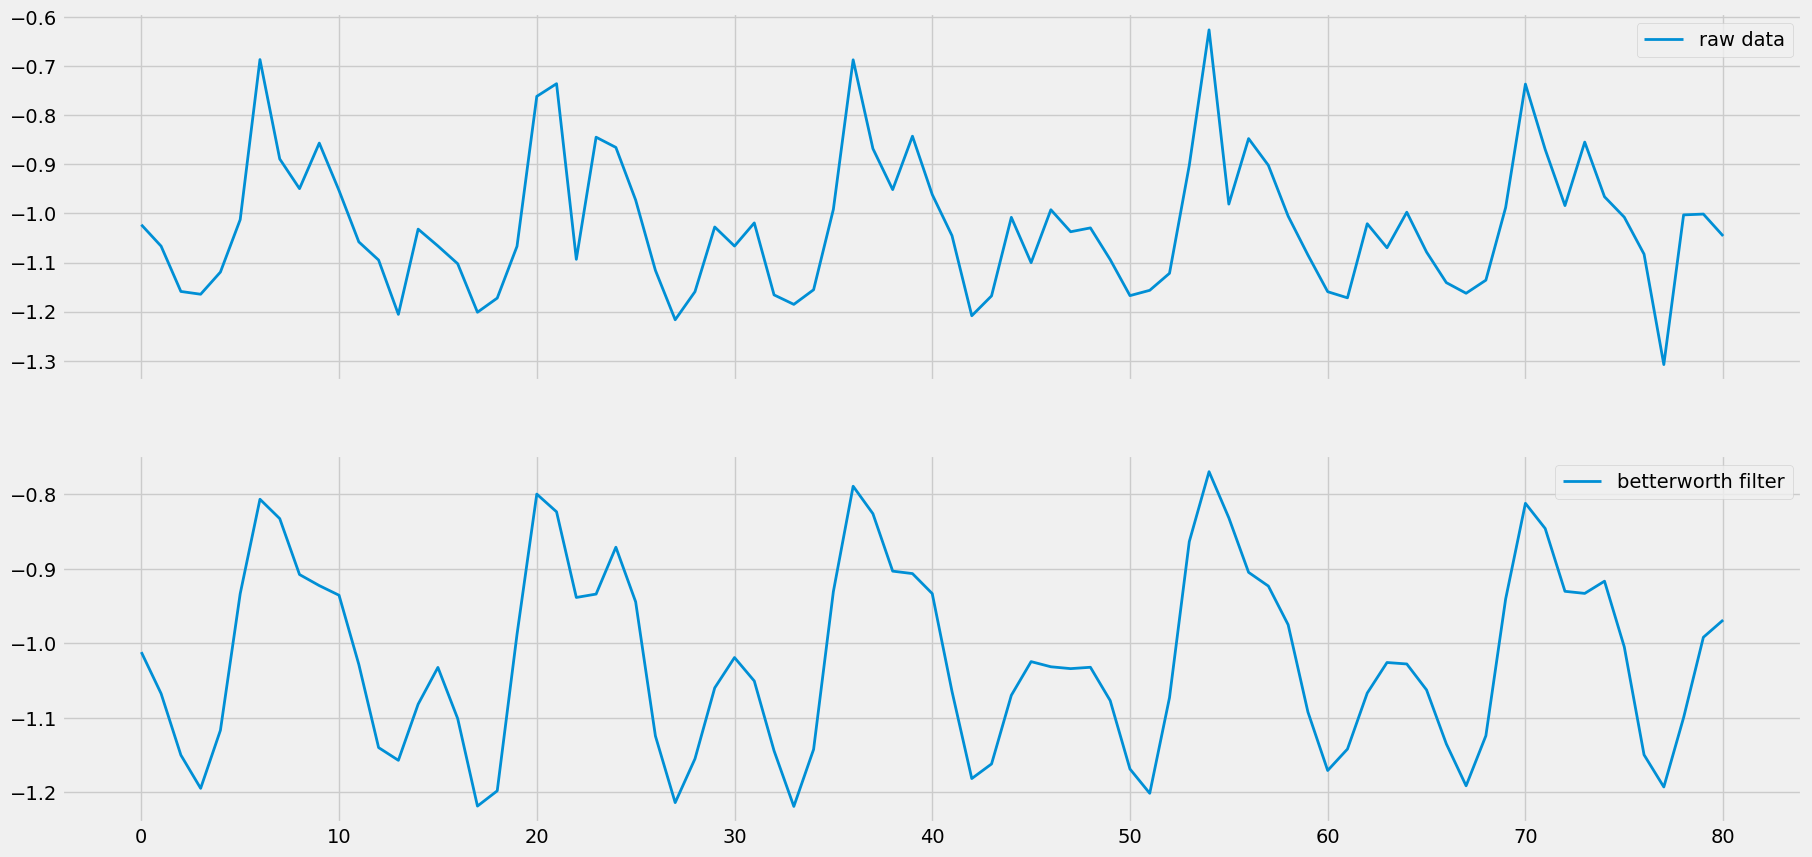

In [14]:
# let's visualize some samples
subset = df_lowpass[df_lowpass['set'] == 5]
print(subset['label'][0])
fig, ax = plt.subplots(nrows = 2, sharex = True, figsize = (20, 10))
ax[0].plot(subset['acc_y'].reset_index(drop = True), label = 'raw data')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop = True), label = 'betterworth filter')
ax[0].legend()
ax[1].legend()

In [15]:
# apply for all the columns and overwrite the original values
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, sf, cutoff, order = 5)
    df_lowpass[col] = df_lowpass[col + '_lowpass']
    df_lowpass.drop(columns = [col + '_lowpass'], inplace = True)

In [16]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0


---

### Principal component analysis PCA

In [17]:
df_pca = df.copy()
pca = PrincipalComponentAnalysis()

pc_values = pca.determine_pc_explained_variance(df_pca, predictor_columns)

In [18]:
pc_values

array([0.55972487, 0.27876279, 0.06404754, 0.05734456, 0.02403143,
       0.0160888 ])

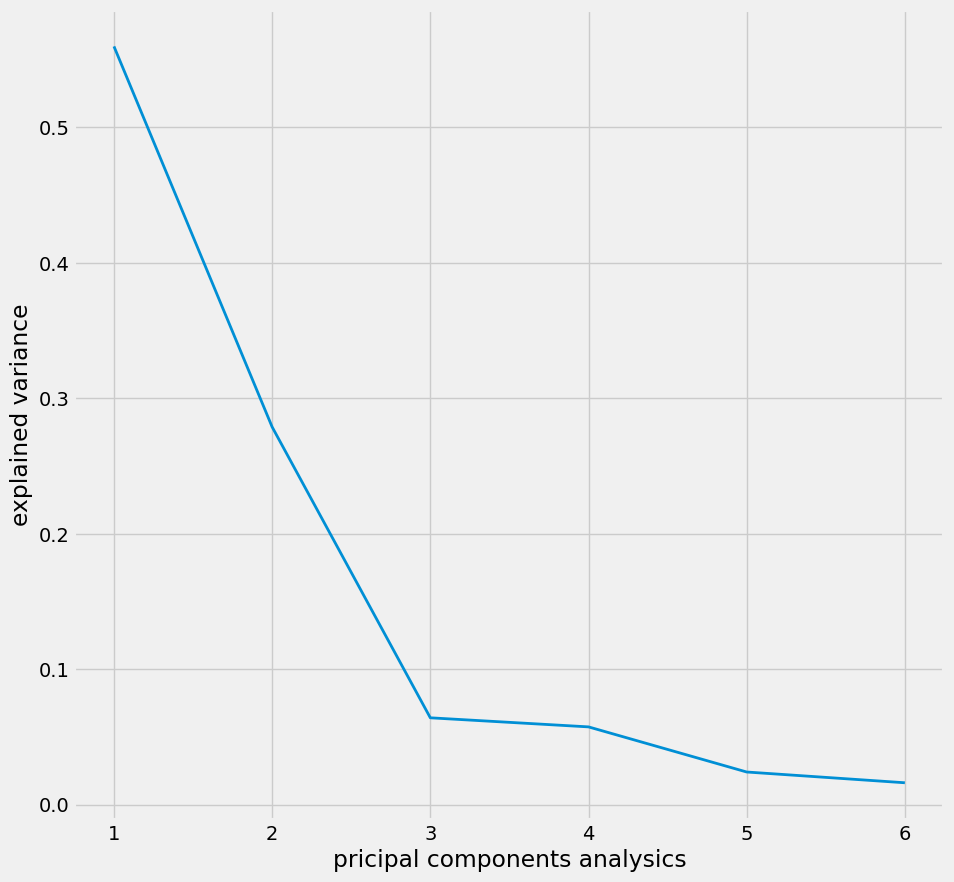

In [19]:
# elow method is used to obtain the optimal pricipal components i.e features
plt.figure(figsize = (10, 10))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel('pricipal components analysics')
plt.ylabel('explained variance')
plt.show()

In [20]:
df_pca = pca.apply_pca(df_pca, predictor_columns, 3)

df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,16.0,-0.291270,-0.077753,-0.004902
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,16.0,-0.290466,-0.084844,-0.003489
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,16.0,-0.290224,-0.075844,-0.024068
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,16.0,-0.287505,-0.084981,-0.045482
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,16.0,-0.289006,-0.108973,-0.024657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,19.0,0.339651,-0.144950,0.010609
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,19.0,0.337364,-0.129861,0.029651
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,19.0,0.335406,-0.149388,0.005035


<AxesSubplot: xlabel='epoch (ms)'>

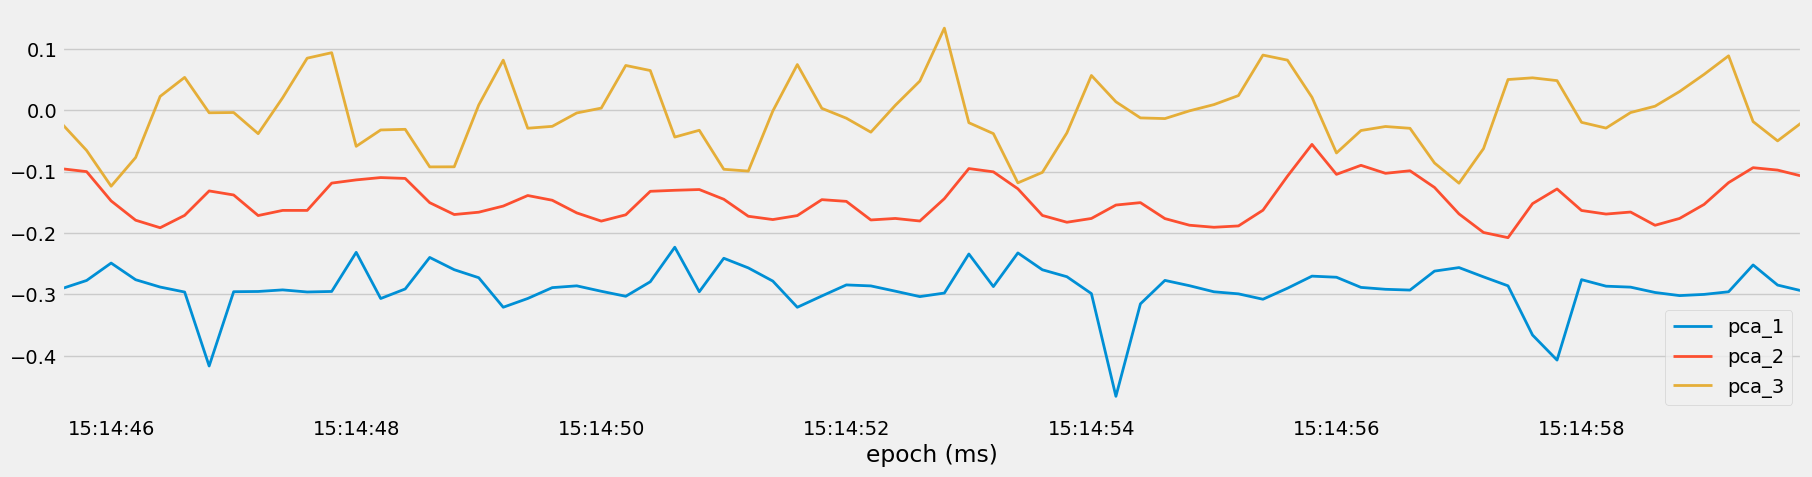

In [21]:
# let's visualize some samples
subset = df_pca[df_pca['set'] == 3]
subset[['pca_1', 'pca_2', 'pca_3']].plot()

---

### Sum of squares attributes

In [22]:
df_squared = df_pca.copy()

df_squared['acc_r'] = np.sqrt(df['acc_x'] ** 2 + df['acc_y'] ** 2 + df['acc_z'] ** 2)
df_squared['gyr_r'] = np.sqrt(df['gyr_x'] ** 2 + df['gyr_y'] ** 2 + df['gyr_z'] ** 2)

In [23]:
df_squared

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,16.0,-0.291270,-0.077753,-0.004902,0.979669,3.225625
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,16.0,-0.290466,-0.084844,-0.003489,0.973752,2.887270
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,16.0,-0.290224,-0.075844,-0.024068,0.973795,2.936720
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,16.0,-0.287505,-0.084981,-0.045482,0.960118,9.473502
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,16.0,-0.289006,-0.108973,-0.024657,0.964953,4.623585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,19.0,0.339651,-0.144950,0.010609,1.045408,5.804424
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,19.0,0.337364,-0.129861,0.029651,1.032376,3.611408
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,19.0,0.335406,-0.149388,0.005035,1.035995,5.869377


array([<AxesSubplot: xlabel='epoch (ms)'>,
       <AxesSubplot: xlabel='epoch (ms)'>], dtype=object)

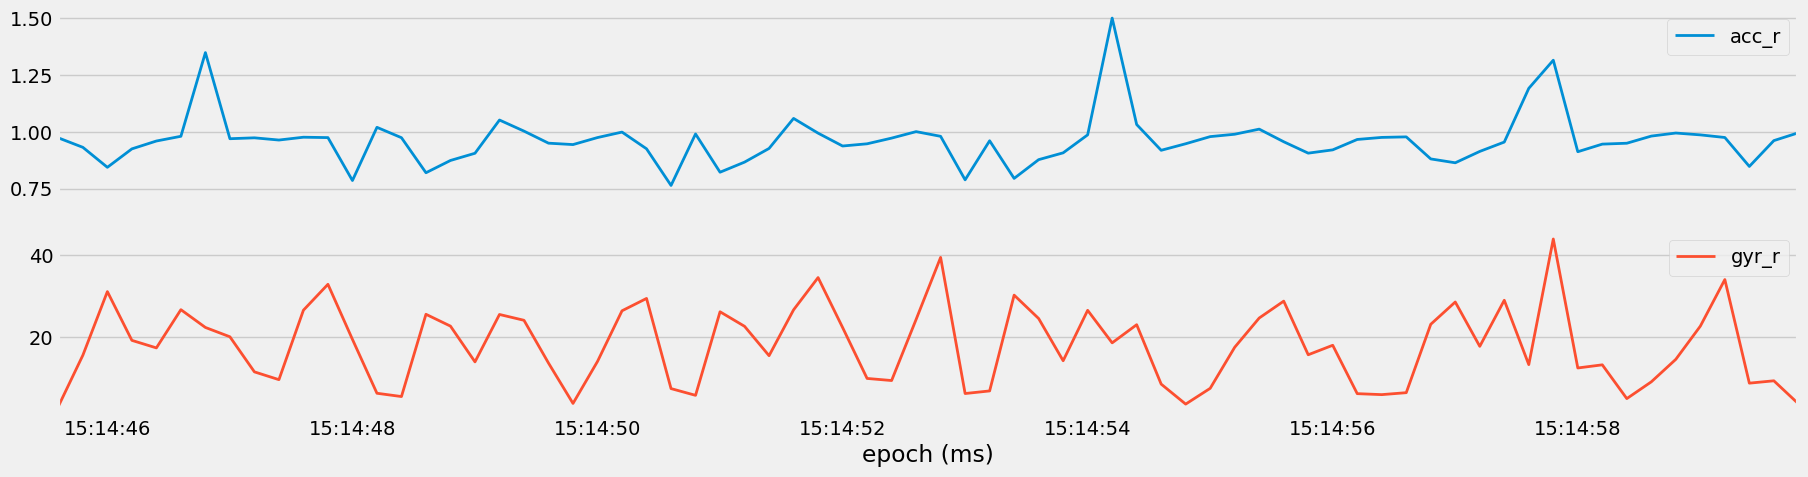

In [24]:
# let's visualize some samples
subset = df_squared[df_squared['set'] == 3]
subset[['acc_r', 'gyr_r']].plot(subplots = True)

---

### Temporal abstraction

In [25]:
df_temporal = df_squared.copy()
NumAbs = NumericalAbstraction()

predictor_columns = list(predictor_columns) + ['acc_r', 'gyr_r']
ws = int(1000 / 200)

In [26]:
for col in predictor_columns:
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, 'mean')
    df_temporal = NumAbs.abstract_numerical(df_temporal, [col], ws, 'std')
# **observations** : here, in some window we will get 2 exercise so taking mean of 2 exercise is not good for our problem
# So, we will loop over each set of exercise and take window for only that set

In [27]:
df_temporal_list = []
for s in df['set'].unique():
    subset = df_temporal[df_temporal['set'] == s]
    subset = NumAbs.abstract_numerical(subset, predictor_columns, ws, 'mean')
    subset = NumAbs.abstract_numerical(subset, predictor_columns, ws, 'std')
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\TemporalAbstraction.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_table[


In [28]:
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_x_temp_mean_ws_5,gyr_x_temp_std_ws_5,gyr_y_temp_mean_ws_5,gyr_y_temp_std_ws_5,gyr_z_temp_mean_ws_5,gyr_z_temp_std_ws_5,acc_r_temp_mean_ws_5,acc_r_temp_std_ws_5,gyr_r_temp_mean_ws_5,gyr_r_temp_std_ws_5
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,...,1.89756,3.630075,-0.95604,2.240819,-0.79756,2.085295,0.970458,0.006986,4.629340,2.503443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,...,-12.82444,19.827605,0.09764,4.801112,7.43648,7.679568,1.108761,0.092007,19.478077,17.763499
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,...,-4.72936,12.757778,-1.38532,3.446955,5.01700,6.998476,1.098030,0.097025,10.986581,12.343920
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,...,1.79504,2.479126,-3.34144,1.894619,1.20240,0.937062,1.051207,0.045487,5.039777,1.023491


<AxesSubplot: xlabel='epoch (ms)'>

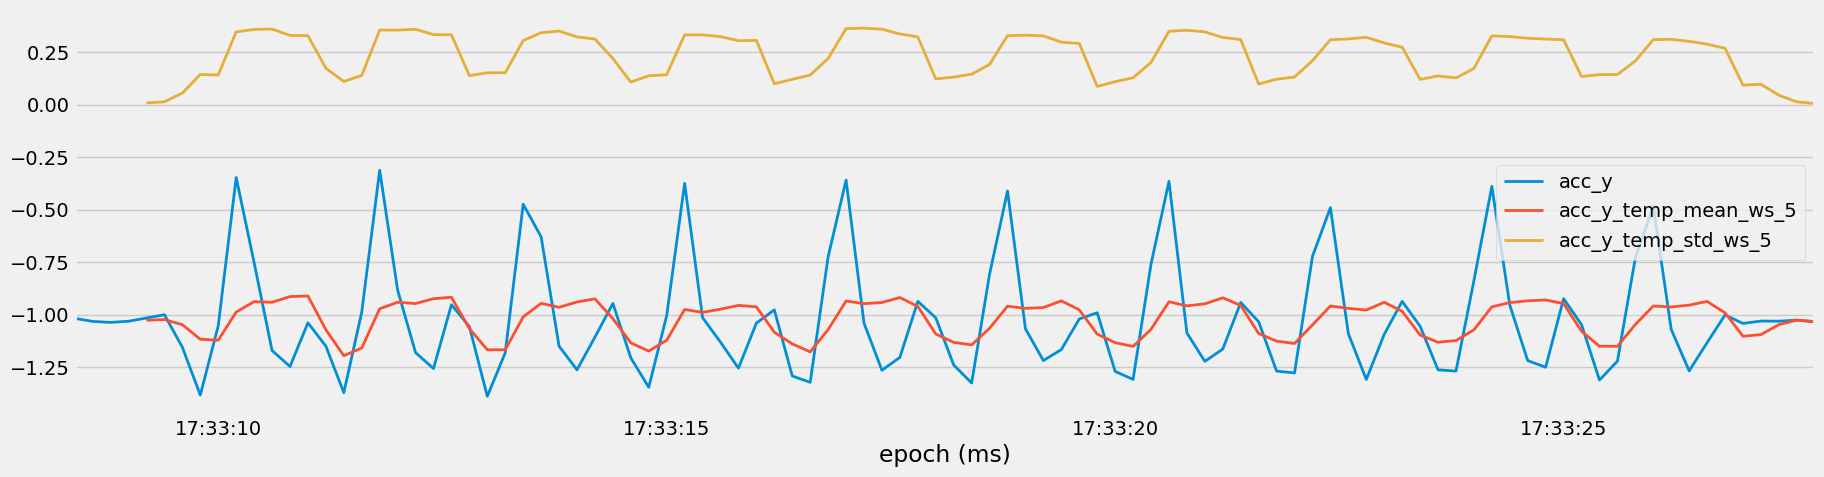

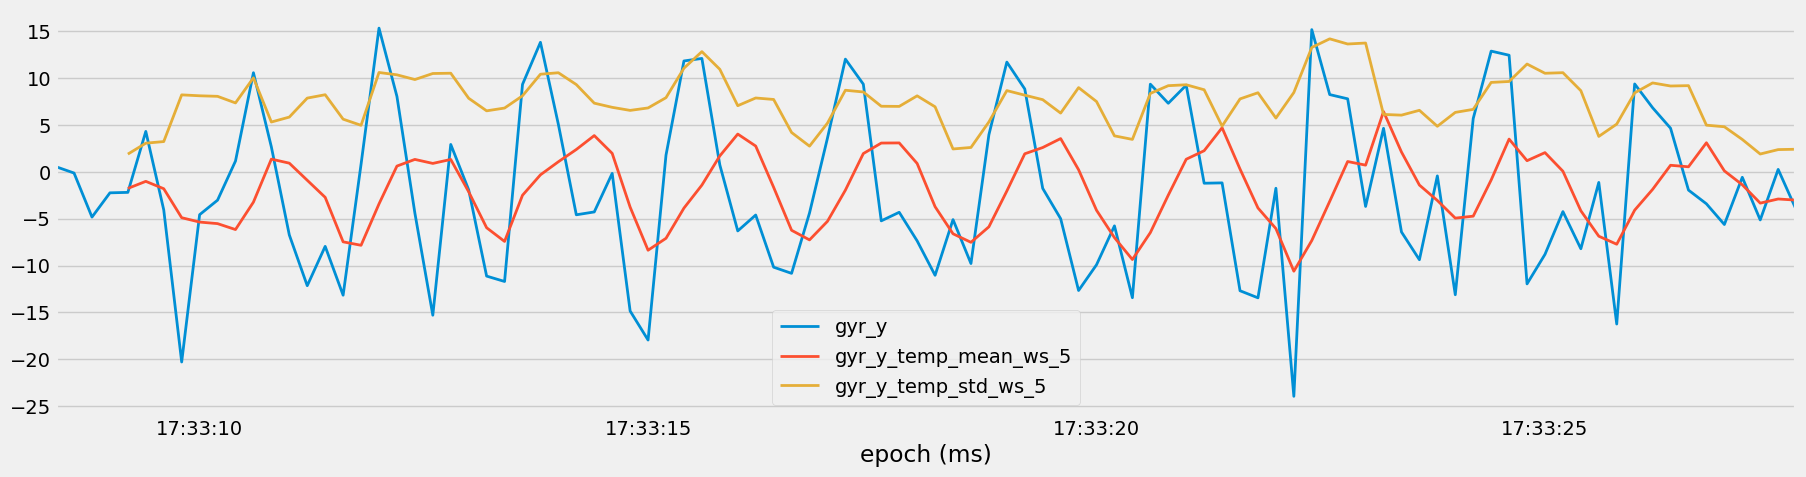

In [29]:
# let's visualize some samples
subset[['acc_y', 'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5']].plot()
subset[['gyr_y', 'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5']].plot()

---

### Frequency features

In [30]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

ws = int(2800 / 200)
sr = int(1000 / 200)
df_freq = FreqAbs.abstract_frequency(df_freq, ['acc_y'], ws, sr)

e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)


<AxesSubplot: >

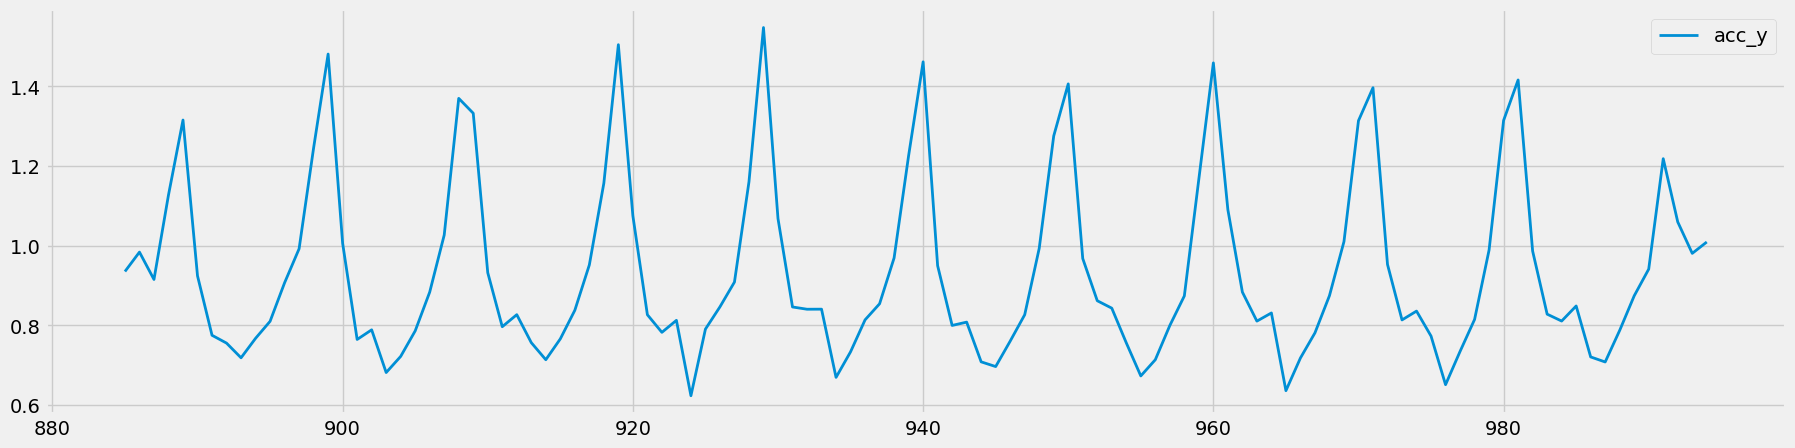

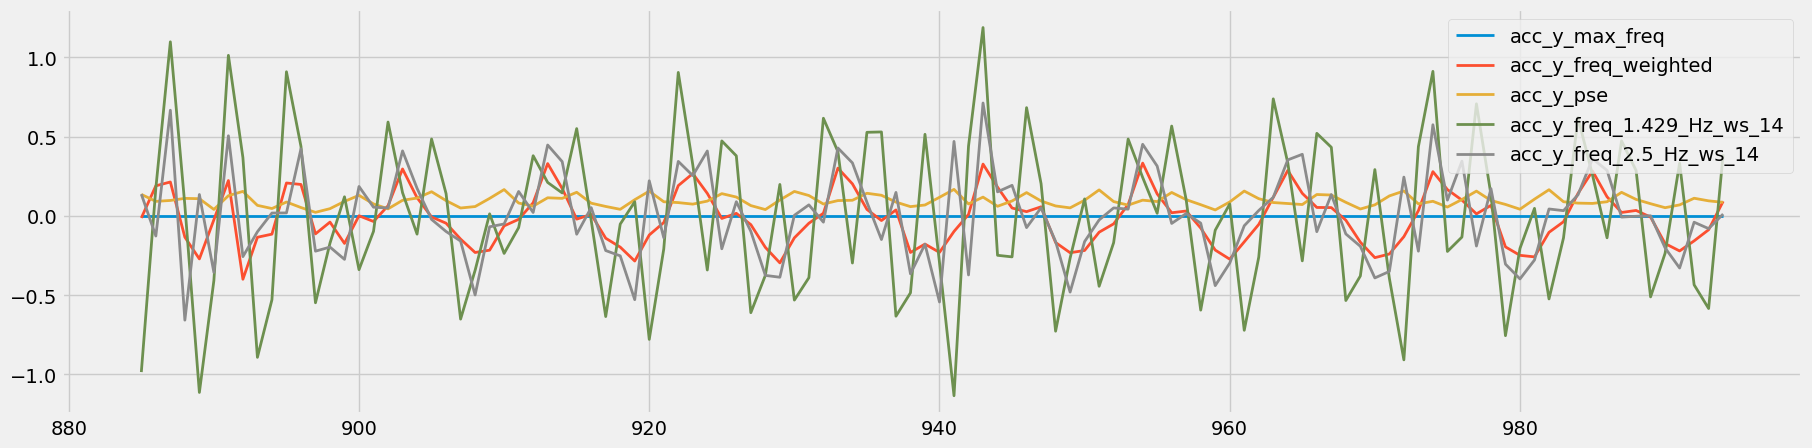

In [31]:
# let's visualize some samples
subset = df_freq[df_freq['set'] == 15]
subset[['acc_y']].plot()
subset[
    [
        'acc_y_max_freq',
        'acc_y_freq_weighted',
        'acc_y_pse',
        'acc_y_freq_1.429_Hz_ws_14',
        'acc_y_freq_2.5_Hz_ws_14'
    ]
].plot()

In [32]:
# for each subset
df_freq_list =[]
for s in df_freq['set'].unique():
    subset = df_freq[df_freq['set'] == s].reset_index(drop = True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, sr)
    df_freq_list.append(subset)
    
df_freq = pd.concat(df_freq_list).set_index('epoch (ms)', drop = True)

e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
e:\PW Skills - Data Science\04_Machine_Learning\Week_ML_Projects\04_Fitness_Tracker\src\features\FrequencyAbstraction.py:67: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
e:\PW Sk

In [33]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,...,-0.509953,0.262948,328.071360,-39.663900,29.883610,2.546553,-10.284092,-56.000494,-12.039831,2.305583
2019-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,...,0.473771,0.732701,320.911687,-42.569654,76.976748,94.956625,-42.364853,56.210236,23.009160,0.081362
2019-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,...,0.670073,0.650708,283.213668,-65.393909,55.066161,51.650214,30.240947,25.798940,12.468238,41.569150


---

### Dealing with overlapping windows

In [34]:
len(df_freq)

9009

In [35]:
df_freq.dropna(inplace = True)
df_freq = df_freq.iloc[::2]

In [36]:
len(df_freq)

3863

---

### Clustering

In [37]:
df_cluster = df_freq.copy()

cluster_columns = ['acc_x', 'acc_y', 'acc_z']
subset = df_cluster[cluster_columns]

In [38]:
subset

,acc_x,acc_y,acc_z
epoch (ms),,,
2019-01-11 15:08:08.000,-0.184333,0.991333,-0.190667
2019-01-11 15:08:08.400,-0.011000,0.850667,-0.094333
2019-01-11 15:08:08.800,-0.065000,0.955333,-0.025333
2019-01-11 15:08:09.200,-0.040667,0.990000,-0.034000
2019-01-11 15:08:09.600,-0.054000,0.946333,-0.068000
...,...,...,...
2019-01-20 17:33:26.000,0.023333,-0.483667,0.200000
2019-01-20 17:33:26.400,0.001667,-1.267667,-0.078667
2019-01-20 17:33:26.800,-0.032333,-1.001000,-0.074667


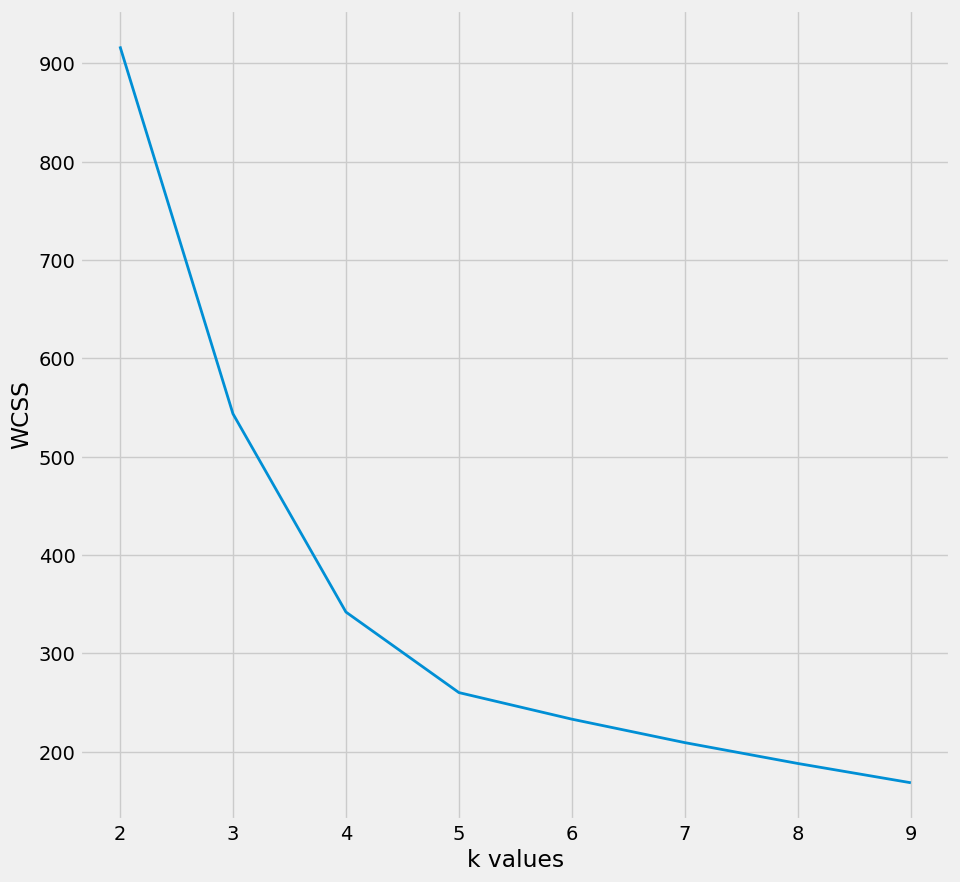

In [39]:
# finding optimal number of centroids 

k_values = range(2, 10)
interias = []

# let's find the wcss value for elbow curve
for k in k_values:
    kmeans = KMeans(n_clusters = k, n_init = 20, random_state = 0)
    cluster_labels = kmeans.fit_predict(subset)
    interias.append(kmeans.inertia_)
        
# let's see elbow curve and decide the optimal k value
plt.figure(figsize = (10, 10))
plt.plot(k_values, interias)
plt.xlabel('k values')
plt.ylabel('WCSS')
plt.show()
# **observations** : We can choose 5 as the optimal k value

In [40]:
# add the cluster column
kmeans = KMeans(n_clusters = 5, n_init = 20, random_state = 0)
df_cluster['cluster'] = kmeans.fit_predict(subset)

In [41]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.184333,0.991333,-0.190667,-28.4268,-13.0854,25.2684,B,bench,heavy,30,...,0.600298,245.584138,-48.335782,16.723521,22.887133,-16.462033,13.505075,-90.019558,3.101760,1
2019-01-11 15:08:08.400,-0.011000,0.850667,-0.094333,12.0852,-0.3536,-5.4024,B,bench,heavy,30,...,0.277713,289.009998,-39.531353,-29.027394,-41.172091,-2.880020,5.499492,-21.546180,6.177948,1
2019-01-11 15:08:08.800,-0.065000,0.955333,-0.025333,1.2684,-3.0246,-1.2318,B,bench,heavy,30,...,0.540112,286.688181,-50.110861,-55.030849,2.663819,-12.836489,-45.736718,57.967366,-5.583470,1
2019-01-11 15:08:09.200,-0.040667,0.990000,-0.034000,2.8538,-2.9390,1.8656,B,bench,heavy,30,...,0.476851,283.912877,-28.514942,38.213692,33.033641,23.097709,34.991662,52.306514,-21.177484,1
2019-01-11 15:08:09.600,-0.054000,0.946333,-0.068000,2.1586,2.7194,-3.8658,B,bench,heavy,30,...,0.590682,230.374271,-26.239333,38.922872,-34.668524,1.381463,34.560586,-24.313563,-49.567671,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.000,0.023333,-0.483667,0.200000,-8.7926,9.3658,0.1342,E,row,medium,90,...,0.482764,347.170845,-17.559995,-55.354330,-91.103222,16.167516,48.095862,-25.078565,5.347692,4
2019-01-20 17:33:26.400,0.001667,-1.267667,-0.078667,-29.7804,4.6464,18.9510,E,row,medium,90,...,0.448131,412.697542,61.755348,-24.017146,77.520934,-46.187130,-64.070276,-21.072239,10.783815,0
2019-01-20 17:33:26.800,-0.032333,-1.001000,-0.074667,4.4754,-3.4146,1.8780,E,row,medium,90,...,0.429302,347.669692,-16.842251,-22.177096,-75.996897,64.861537,22.968427,21.862325,22.009788,0


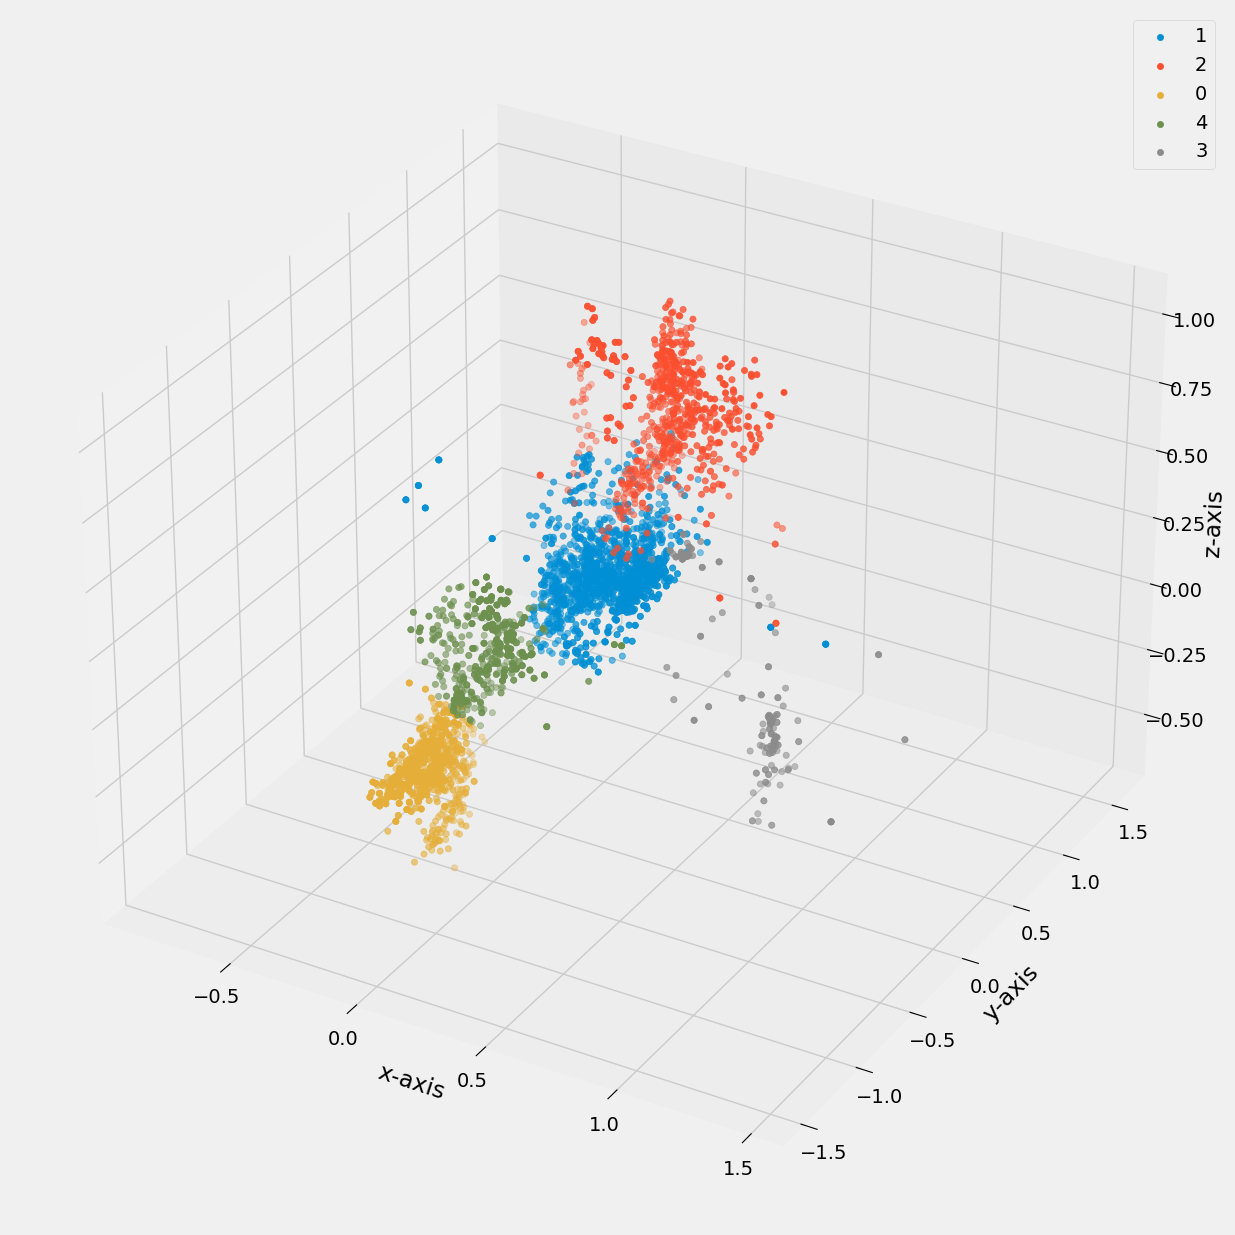

In [42]:
# plot the cluster by cluster group
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(projection = '3d')
for c in df_cluster['cluster'].unique():
    subset = df_cluster[df_cluster['cluster'] == c]
    ax.scatter(subset['acc_x'], subset['acc_y'], subset['acc_z'], label = c)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.legend()
plt.show()

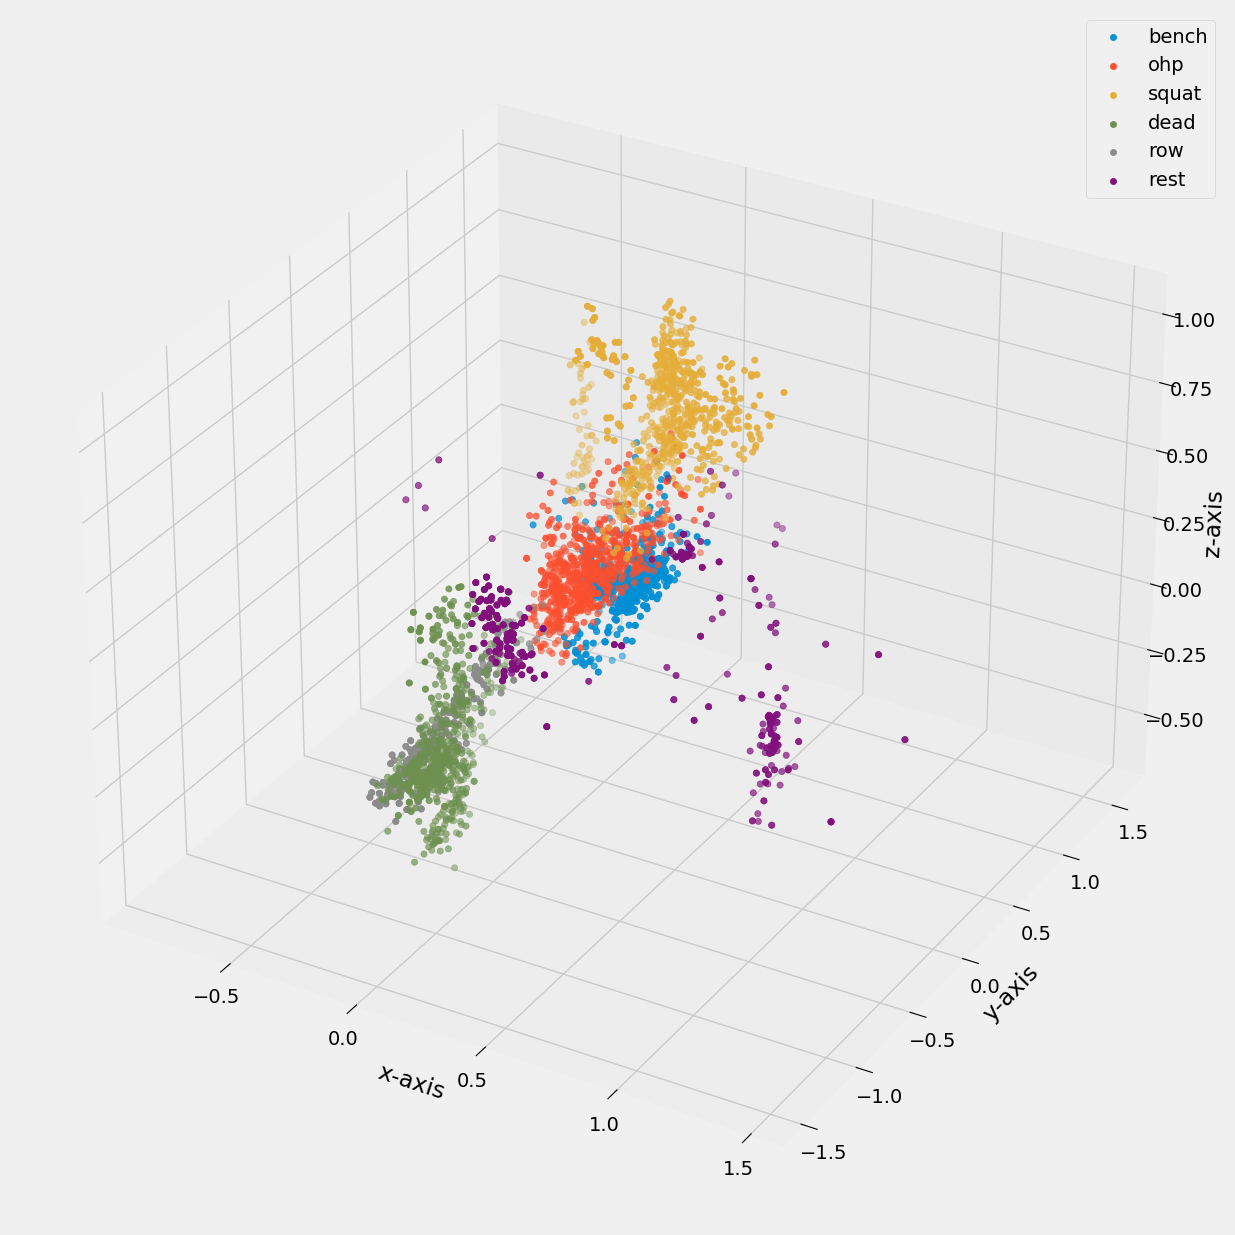

In [43]:
# plot the cluster by label
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(projection = '3d')
for c in df_cluster['label'].unique():
    subset = df_cluster[df_cluster['label'] == c]
    ax.scatter(subset['acc_x'], subset['acc_y'], subset['acc_z'], label = c)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.legend()
plt.show()
# **observation** : we can see that some cluster are close to each other so they are merged in above plot but actual group we go here.
# bench and overhead press are close to each other as there moment is also same they give similar reading

---

### Export Dataset

In [44]:
df_cluster.to_pickle('../../data/interim/03_data_features.pkl')

---